# Visualising Simplicial Laplacian 1-Eigenvectors

In this notebook, we develop a few examples of using de rham networks to visualise the 1-eigenvectors of the simplicial laplacian.

In [1]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors


from sklearn.datasets import make_circles
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd

# for building the boundary matrices
from scipy import sparse
from scipy.sparse import coo_matrix,diags

import cochainlearning as cl

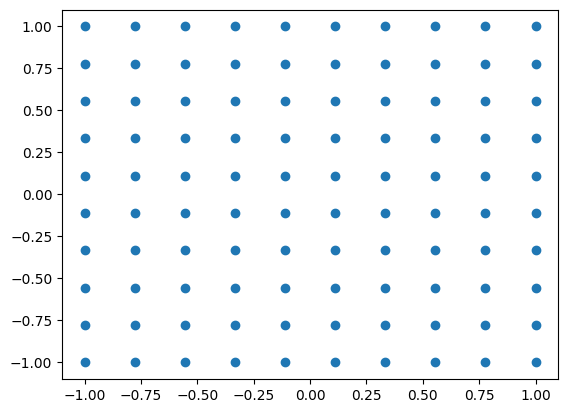

In [2]:
# make a grid of points in the square [-1,1]x[-1,1]

# number of points in each direction
n = 10

# grid of x values
x = np.linspace(-1,1,n)

# grid of y values
y = np.linspace(-1,1,n)

# grid of points
X,Y = np.meshgrid(x,y)

# reshape into a list of points
data = np.vstack([X.ravel(),Y.ravel()]).T

# plot the points
plt.scatter(data[:,0], data[:,1])
plt.show()

In [3]:


from gudhi import AlphaComplex

# build a simplex tree
ac = AlphaComplex(points = data)
st = ac.create_simplex_tree()

# extract simplices
simplices = cl.extract_simplices(st)

# build the boundary matrices and laplacian
boundaries = cl.build_boundaries(simplices)
laplacian = boundaries[0].T @ boundaries[0] + boundaries[1] @ boundaries[1].T

In [4]:
laplacian

<261x261 sparse matrix of type '<class 'numpy.float32'>'
	with 1609 stored elements in Compressed Sparse Row format>

In [5]:
laplacian = np.array(laplacian.todense())
laplacian.shape

(261, 261)

In [6]:
# only calculate the first 10 eigenvectors of the laplacian corresponding to the first 10 eigenvalues without calculating the full set of eigenvectors
eigvals, eigvecs = sparse.linalg.eigsh(laplacian, k=10, which='SM')

In [7]:
eigvecs = torch.tensor(eigvecs).float()

## Representing the simplicial complex as a chain

In [8]:
# a function for turning a path into a chain
def complex_to_chain(one_simplices, points):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A set of 1-simplices extracted from the Gudhi simplex tree

    points : numpy array
        A set of vertices corresponding to the embedding

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(one_simplices)

    n = points[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    for i in range(r):

        chain[i,0,:] = torch.tensor(points[one_simplices[i][0]])
        chain[i,1,:] = torch.tensor(points[one_simplices[i][1]])
    

    return chain

In [9]:
# extract simpices
simplices = cl.extract_simplices(st)

one_simplices = [np.sort(list(elem)) for elem in simplices[1].keys()]


one_simplices
chain = complex_to_chain(one_simplices, data)
chain.shape

torch.Size([261, 2, 2])

In [10]:
data[one_simplices[0][1]]

array([-0.77777778, -1.        ])

## Learning Vector Fields in R^2 which Correspond to the Eigenvectors of the Simplicial Laplacian

In [12]:
c = 10 # number of features/columns in cochain data matrix (corresponds to 10 eigenvectors)

vf = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 30),
    nn.ReLU(),
    nn.Linear(30, 2*c)
)

### Do the Training

In [13]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)



In [14]:
epoch = 2000

for i in range(epoch):

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    X = cl.gen_CDM(vf,chain)
    diff = X - eigvecs
    L = torch.sum(torch.diag(diff @ diff.T))
    L.backward()
    optimizer.step()    # Does the update

    if i % 10 == 0:
        print("Iteration: ", i, "Loss: ", L)

Iteration:  0 Loss:  tensor(10.2442, grad_fn=<SumBackward0>)
Iteration:  10 Loss:  tensor(9.1862, grad_fn=<SumBackward0>)
Iteration:  20 Loss:  tensor(8.6242, grad_fn=<SumBackward0>)
Iteration:  30 Loss:  tensor(8.2691, grad_fn=<SumBackward0>)
Iteration:  40 Loss:  tensor(8.0265, grad_fn=<SumBackward0>)
Iteration:  50 Loss:  tensor(7.8454, grad_fn=<SumBackward0>)
Iteration:  60 Loss:  tensor(7.6962, grad_fn=<SumBackward0>)
Iteration:  70 Loss:  tensor(7.5625, grad_fn=<SumBackward0>)
Iteration:  80 Loss:  tensor(7.4354, grad_fn=<SumBackward0>)
Iteration:  90 Loss:  tensor(7.3126, grad_fn=<SumBackward0>)
Iteration:  100 Loss:  tensor(7.1932, grad_fn=<SumBackward0>)
Iteration:  110 Loss:  tensor(7.0768, grad_fn=<SumBackward0>)
Iteration:  120 Loss:  tensor(6.9641, grad_fn=<SumBackward0>)
Iteration:  130 Loss:  tensor(6.8559, grad_fn=<SumBackward0>)
Iteration:  140 Loss:  tensor(6.7534, grad_fn=<SumBackward0>)
Iteration:  150 Loss:  tensor(6.6575, grad_fn=<SumBackward0>)
Iteration:  160 Lo

In [15]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5, c = 10, resolution = 40):
    """ 
    A function for plotting a component of a vector field given a function f: R^2 -> R^2

    Parameters
    ----------
    f : a Pytorch Sequential object
        A function f: R^2 -> R^2, represented as a Pytorch Sequential object
    
    ax : matplotlib axis object
        The axis on which to plot the vector field

    comp : int
        The component of the vector field to plot

    x_range : float
        The range of x values to plot
    
    y_range : float
        The range of y values to plot

    Returns
    -------
    None
    """
    x = np.linspace(-x_range,x_range,resolution)
    y = np.linspace(-y_range,y_range,resolution)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((resolution,resolution))
    V = np.zeros((resolution,resolution))
    for i in range(resolution):
        for j in range(resolution):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()
            tv = f.forward(inp).reshape(2,c)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_849/475380239.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i+1)


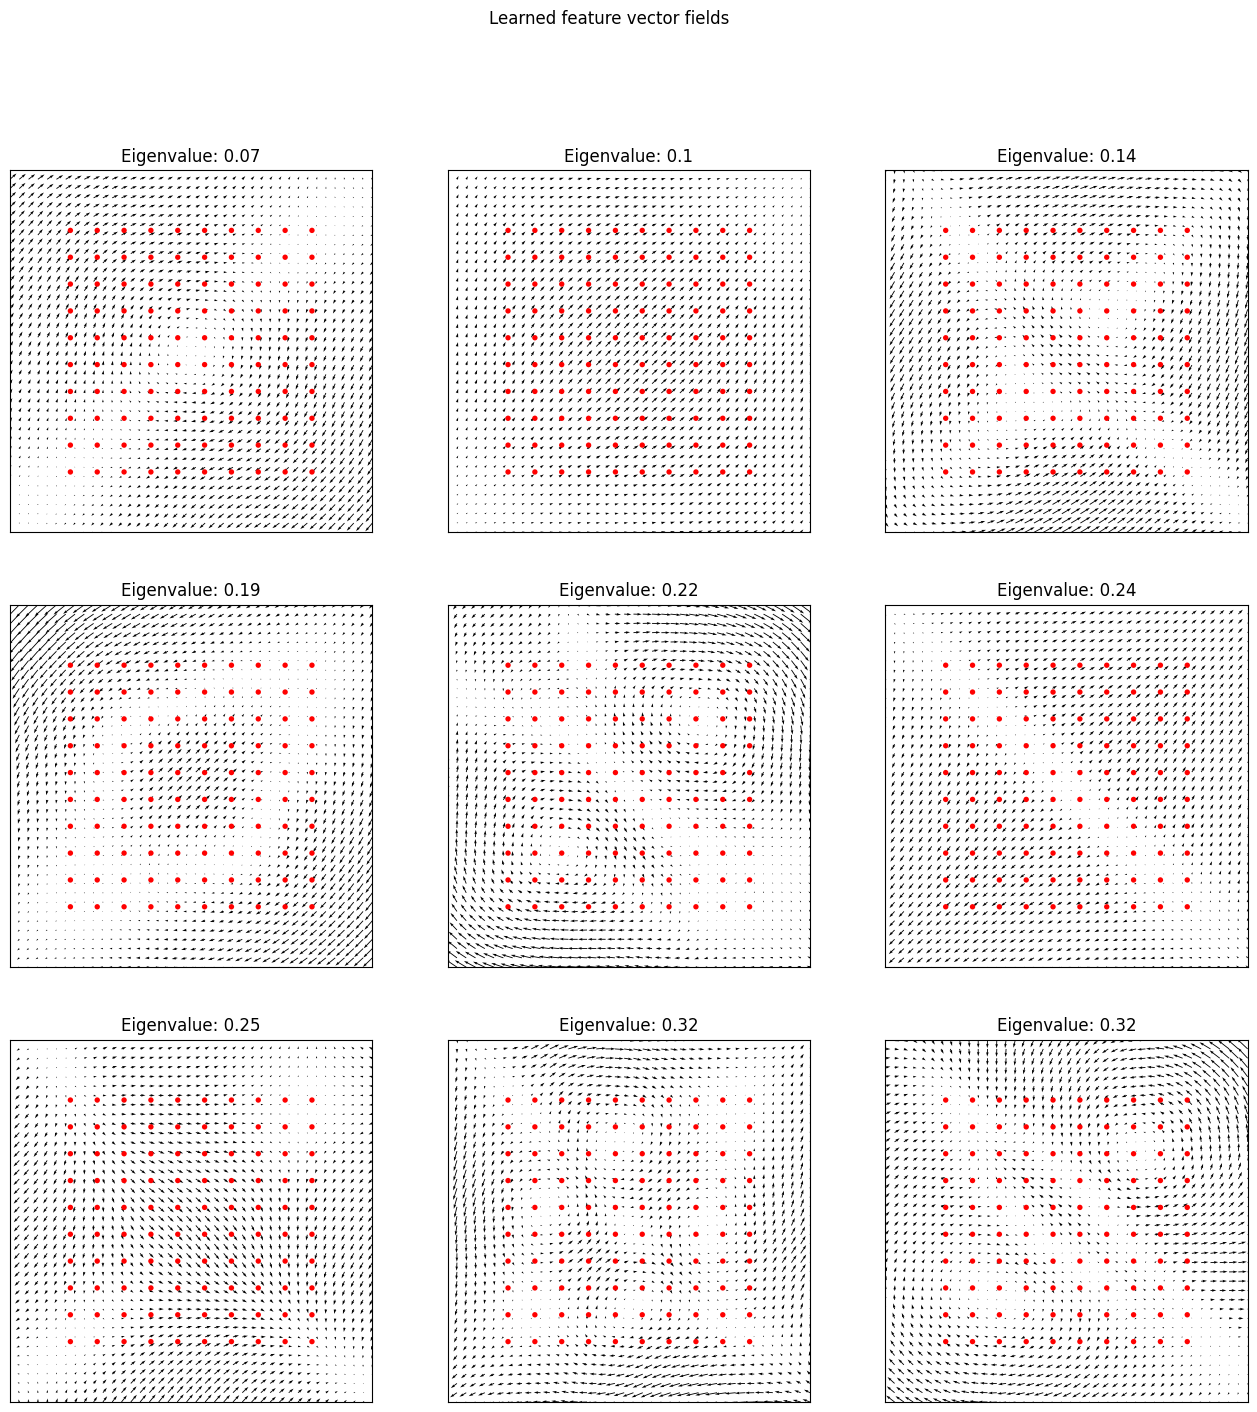

In [16]:
fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=1.5, y_range=1.5)


    # overlot the point cloud onto each subplot
     
    ax.scatter(data[:,0], data[:,1], s=15, c='red', alpha=1, marker='o', edgecolors='none')
    
    # make the points a bit bigger
    


    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    # add a title to each subplot with i-th eigenvalue (up to 2 decimal places) corresponding to the i-th subplot 
    ax.set_title('Eigenvalue: ' + str(np.round(eigvals[i],2)))
    



# make the figure a bit bigger
fig.set_size_inches(16,16)


# add a title to the figure
fig.suptitle('Learned feature vector fields')

plt.show()

## Rotational Orbit Learning


In [190]:
# a function for turning a path into a chain
def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = p[1:,:]
    chain[:,0,:] = p[0:-1,:]

    return chain.requires_grad_()

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = torch.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain

# a function for turning a chain into a cochain data matrix
def gen_CDM(vf,chain, d = 5):
    """
    A function for generating a cochain data matrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features / n)

    # apply the vector field to the discretized chain
    out = vf(chain).reshape((r,d,n,c))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

# a function for calculating the length of a path
def path_length(path):
    """
    Calculates the length of a path
    """
    length = 0
    for i in range(len(path)-1):
        length += (path[i+1]-path[i]).T @ (path[i+1]-path[i])
    return length

torch.Size([100, 2, 10])


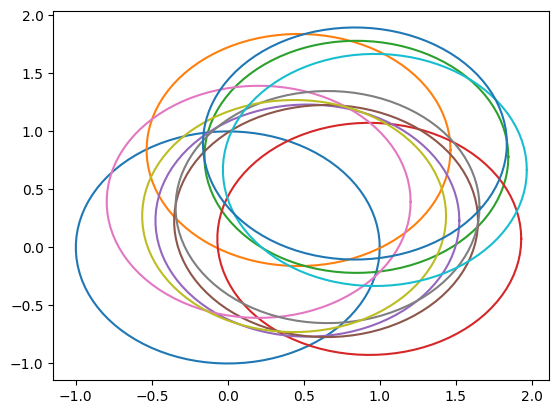

In [577]:
# make a unit circle with s points
s = 100
theta = np.linspace(0,2*np.pi,s)

x = np.cos(theta)
y = np.sin(theta)

# merge x and y into a single array
circle =torch.tensor([x,y]).float().T

# plot the unit circle
plt.plot((circle)[:,0],(circle)[:,1])

# generate k random vectors in 2d uniformly distributed on the unit square
k = 10
v = torch.rand(k,2)


total = torch.zeros(s,2,k)

for i in range(k):
    total[:,:,i] = circle + v[i]




print(total.shape)

for i in range(k):
    plt.plot(total[:,0,i],total[:,1,i])

In [314]:
s_embed(circle)

tensor([[-0.4094,  0.1188],
        [-0.3966,  0.1179],
        [-0.3895,  0.1176],
        [-0.3875,  0.1179],
        [-0.3856,  0.1182],
        [-0.3839,  0.1185],
        [-0.3824,  0.1187],
        [-0.3812,  0.1189],
        [-0.3801,  0.1190],
        [-0.3792,  0.1192],
        [-0.3786,  0.1193],
        [-0.3781,  0.1193],
        [-0.3780,  0.1194],
        [-0.3788,  0.1195],
        [-0.3798,  0.1196],
        [-0.3812,  0.1197],
        [-0.3828,  0.1198],
        [-0.3843,  0.1197],
        [-0.3859,  0.1196],
        [-0.3878,  0.1195],
        [-0.3900,  0.1194],
        [-0.3923,  0.1192],
        [-0.3947,  0.1190],
        [-0.3973,  0.1188],
        [-0.4000,  0.1185],
        [-0.4029,  0.1182],
        [-0.4058,  0.1179],
        [-0.4089,  0.1175],
        [-0.4120,  0.1172],
        [-0.4152,  0.1168],
        [-0.4185,  0.1163],
        [-0.4218,  0.1159],
        [-0.4251,  0.1154],
        [-0.4285,  0.1149],
        [-0.4319,  0.1144],
        [-0.4352,  0

In [315]:
chain = path_to_chain(s_embed(circle))

In [316]:

gen_CDM(vf,chain)

tensor([[-6.5705e-04, -4.3303e-03, -4.4253e-03,  3.3904e-03,  2.3325e-03,
         -1.3653e-03,  2.8289e-03, -1.3345e-03,  3.6205e-04, -2.0941e-03],
        [-4.1152e-04, -2.5152e-03, -2.4474e-03,  1.9769e-03,  1.2650e-03,
         -7.7495e-04,  1.5100e-03, -7.5214e-04,  2.0212e-04, -1.1732e-03],
        [-2.1227e-04, -8.9645e-04, -6.9388e-04,  6.6797e-04,  3.4995e-04,
         -3.0088e-04,  3.2031e-04, -2.2592e-04,  3.0746e-06, -3.6407e-04],
        [-1.9307e-04, -8.1900e-04, -6.3315e-04,  6.1273e-04,  3.1840e-04,
         -2.7175e-04,  2.9362e-04, -2.0765e-04,  5.1393e-06, -3.3305e-04],
        [-1.7328e-04, -7.3798e-04, -5.6988e-04,  5.5413e-04,  2.8584e-04,
         -2.4232e-04,  2.6538e-04, -1.8812e-04,  6.5303e-06, -3.0046e-04],
        [-1.5294e-04, -6.5369e-04, -5.0429e-04,  4.9243e-04,  2.5234e-04,
         -2.1263e-04,  2.3569e-04, -1.6743e-04,  7.2793e-06, -2.6643e-04],
        [-1.3213e-04, -5.6655e-04, -4.3669e-04,  4.2799e-04,  2.1807e-04,
         -1.8276e-04,  2.0475e-0

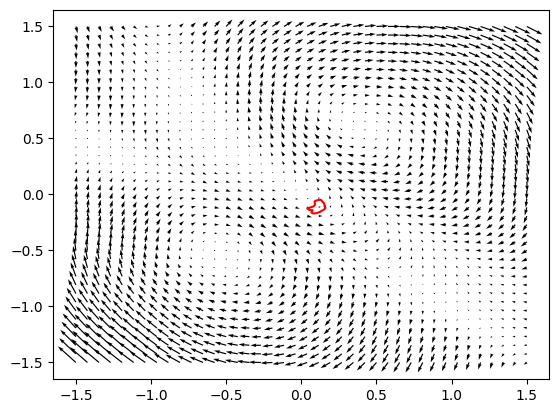

In [557]:
# plot the 4th component of the vector field and overlay embedding 
fig, ax = plt.subplots()

# initialise a neural network from R^2 to R^2
s_embed = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
    nn.ReLU(),
    nn.Linear(30, 2)
)


plot_component_vf(vf, ax, comp = 4, x_range=1.5, y_range=1.5)

# plot the s_embed function on the unit circle
embedding = s_embed.forward(circle).detach().numpy()


# over embedding onto the plot as a line plot
ax.plot(embedding[:,0],embedding[:,1], c='red')

In [558]:
import torch.optim as optim

# create your optimizer
optimizer2 = optim.SGD(s_embed.parameters(), lr=1e-2)

# initialise  cross entropy loss
criterion = nn.CrossEntropyLoss()





In [559]:
vf2 = vf.forward

In [560]:
epoch = 1000

vf_comp = 4



for i in range(epoch):


    #print("Iteration: ", i)
    vf.requires_grad = False

    embedding = s_embed.forward(circle)



    chain = path_to_chain(embedding)

    # zero the gradient buffers
    

    X = gen_CDM(vf,chain)

    mids = (chain[:,0,:]+chain[:,1,:])/2

    diam = 1.5
    scale = torch.exp(- ( torch.diag(mids @ mids.T) / diam )**10)


    X = torch.mul(scale ,X[:,vf_comp])

    # replace X with its softmax

    sm = nn.functional.softmax(X)




    #L = s * X.sum() + 25*criterion(sm, torch.ones(sm.shape[0])/sm.shape[0])

    diff = X - torch.ones(X.shape[0])/5

    L = diff.T @ diff
     

    #print("Loss: ", L)

    




    #L = X[:,vf_comp].T @ X[:,vf_comp]
    # s_embed.requires_grad = True
    L.backward()

    # print the grad of the parameters of s_embed
    #for param in s_embed.parameters():
    #    print("Grad ", param.grad.sum())
    

    optimizer2.step()    # Does the update
    


    # in your training loop:
    optimizer2.zero_grad()  


    if i % 10 == 0:
        print("Iteration: ", i, "Loss: ", L)


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_4215/1483905344.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = nn.functional.softmax(X)


Iteration:  0 Loss:  tensor(3.9665, grad_fn=<DotBackward0>)
Iteration:  10 Loss:  tensor(3.9654, grad_fn=<DotBackward0>)
Iteration:  20 Loss:  tensor(3.9643, grad_fn=<DotBackward0>)
Iteration:  30 Loss:  tensor(3.9634, grad_fn=<DotBackward0>)
Iteration:  40 Loss:  tensor(3.9625, grad_fn=<DotBackward0>)
Iteration:  50 Loss:  tensor(3.9617, grad_fn=<DotBackward0>)
Iteration:  60 Loss:  tensor(3.9609, grad_fn=<DotBackward0>)
Iteration:  70 Loss:  tensor(3.9601, grad_fn=<DotBackward0>)
Iteration:  80 Loss:  tensor(3.9593, grad_fn=<DotBackward0>)
Iteration:  90 Loss:  tensor(3.9585, grad_fn=<DotBackward0>)
Iteration:  100 Loss:  tensor(3.9576, grad_fn=<DotBackward0>)
Iteration:  110 Loss:  tensor(3.9567, grad_fn=<DotBackward0>)
Iteration:  120 Loss:  tensor(3.9557, grad_fn=<DotBackward0>)
Iteration:  130 Loss:  tensor(3.9546, grad_fn=<DotBackward0>)
Iteration:  140 Loss:  tensor(3.9533, grad_fn=<DotBackward0>)
Iteration:  150 Loss:  tensor(3.9519, grad_fn=<DotBackward0>)
Iteration:  160 Los

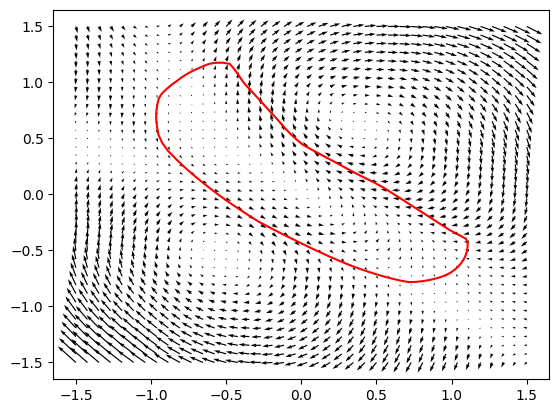

In [562]:
# plot the 4th component of the vector field and overlay embedding 
fig, ax = plt.subplots()


plot_component_vf(vf, ax, comp = 4, x_range=1.5, y_range=1.5)




embedding = s_embed.forward(circle).detach().numpy()


# over embedding onto the plot as a line plot, color the lines between points by vals
ax.plot(embedding[:,0],embedding[:,1], c='red')




In [503]:
mids = (chain[:,0,:]+chain[:,1,:])/2

diam = 1
scale = torch.exp(- ( torch.diag(mids @ mids.T) / diam )**10)
print(scale)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.7455e-15, 2.9293e-02, 8.6526e-01, 9.9994e-01,
        1.0000e+00, 1.0000e+00, 9.9996e-01, 9.5296e-01, 3.0713e-01, 8.5829e-04,
        2.6793e-02, 5.6818e-01, 4.4862e-01, 5.6782e-06, 8.8065e-08, 9.4882e-01,
        9.0409e-01, 4.1637e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 7.2389e-13, 9.9979e-01, 1.0000e+00, 1.0000e+00, 9.9458e-01,
        6.0732e-01, 2.3419e-05, 3.8315e-15, 6.6362e-14, 1.1406e-06, 1.5238e-04,
        2.0909e-09, 0.0000e+00, 0.0000e+

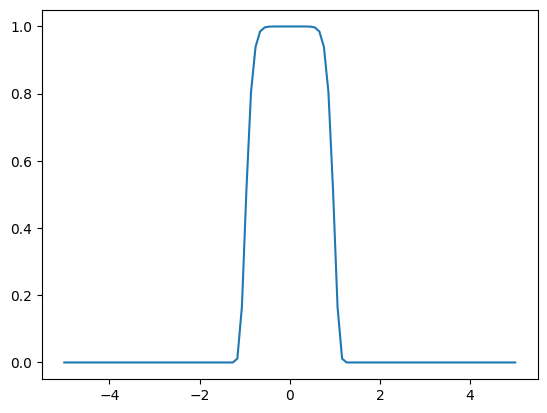

In [260]:
# plot the function exp(-x^2/ep) over the real line
x = np.linspace(-5,5,100)
y = np.exp(-(x/1)** 10)

fig, ax = plt.subplots()

ax.plot(x,y)


In [64]:
U2.shape

(665, 665)

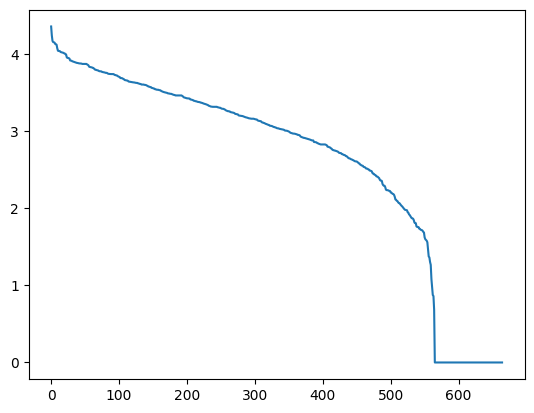

In [65]:
# plot S2
plt.plot(S2)
plt.show()